In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import os
from pathlib import Path

#import cv2

import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split
#from pdb import set_trace as st

#import pretrainedmodels as pm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

#from albumentations import Compose, JpegCompression, CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, \
#        Blur, OpticalDistortion, GridDistortion, HueSaturationValue, Flip, VerticalFlip

from kekas import Keker, DataOwner, DataKek
from kekas.transformations import Transformer, to_torch, normalize
from kekas.metrics import accuracy
from kekas.modules import Flatten, AdaptiveConcatPool2d
from kekas.callbacks import Callback, Callbacks, DebuggerCallback

/home/roma/.virtualenvs/aseg_torch1/lib/python3.6/site-packages/kekas/keker.py:9: UserWarning: Error 'No module named 'apex''' during importing apex library. To use mixed precison you should install it from https://github.com/NVIDIA/apex
  warnings.warn(f"Error '{e}'' during importing apex library. To use mixed precison"


In [3]:
import fastai_sparse # 3D 

In [4]:
import sparseconvnet as scn

from fastai_sparse import utils, visualize
from fastai_sparse.utils import log
#from fastai_sparse.data import DataSourceConfig, MeshesDataset, SparseDataBunch
#from fastai_sparse.learner import SparseModelConfig, Learner
#from fastai_sparse.callbacks import TimeLogger, SaveModelCallback, CSVLogger
from fastai_sparse.transforms import Transform, Compose

from data import merge_fn

# Experiment environment and system metrics

In [5]:
#import neptune
#from neptune_callbacks import NeptuneMonitor

In [6]:
params={'n_epoch': 256+128,
        'max_lr': 2.0,
        'wd':0.0001
        }
params

{'n_epoch': 384, 'max_lr': 2.0, 'wd': 0.0001}

In [7]:
#with open('NEPTUNE_API_TOKEN.txt','r') as f:
#    NEPTUNE_API_TOKEN = f.readline().splitlines()[0]
#    
#neptune.init(api_token=NEPTUNE_API_TOKEN,
#             project_qualified_name='roma-goodok/fastai-sparse-scannet')
#
## create experiment in the project defined above
#exp = neptune.create_experiment(params=params)
#print(exp.id)
#exp.append_tag('study')
#exp.append_tag('kekas')
#exp.append_tag('unet24')
#exp.append_tag('1cycle')

In [8]:
try:
    experiment_name = exp.id
except Exception as e:
    experiment_name = "kekas"

print("Experiment:", experiment_name)
logdir = os.path.join('logdir', experiment_name)
Path(logdir).mkdir(parents=True, exist_ok=True)
print("Logdir:", logdir)

Experiment: kekas
Logdir: logdir/kekas


In [9]:
utils.watermark(pandas=True, kekas=True)

virtualenv:     (aseg_torch1) 
python:         3.6.8
nvidia driver:  b'384.130'
nvidia cuda:    9.0, V9.0.176
cudnn:          7.1.4
torch:          1.0.0
pandas:         0.24.2
kekas:          0.1.17
fastai:         1.0.48
fastai_sparse:  0.0.4.dev0


In [10]:
!git log1 -n3

0704795 Updates
69d33ec lr_find
a24855f Updates


In [11]:
!nvidia-smi

Fri Apr 19 01:17:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:28:00.0  On |                  N/A |
| 18%   59C    P8    25W / 250W |   1183MiB / 11163MiB |     43%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:29:00.0 Off |                  N/A |
| 30%   61C    P0    80W / 250W |     11MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [12]:
!lscpu | grep "Model"

Model name:            AMD Ryzen 7 1700 Eight-Core Processor


## Jupyter notebook display options

In [13]:
utils.wide_notebook()
# uncomment this lines if you want switch off interactive and save visaulisation as screenshoots:
# For rendering run command in terminal:    `chromium-browser --remote-debugging-port=9222`
if  True:
    visualize.options.interactive = False
    visualize.options.save_images = True
    visualize.options.verbose = True
    visualize.options.filename_pattern_image = Path('images', experiment_name, 'fig_{fig_number}')

# Dataset creation

## Downloading

see how download and preprocess data by the following link from fastai_sparse library: https://github.com/goodok/fastai_sparse/tree/master/examples/scannet/data

In [14]:
SOURCE_DIR = Path('data', 'scannet_merged_ply')
assert SOURCE_DIR.exists(), "Run prepare_data.ipynb"

definition_of_spliting_dir = Path('data', 'ScanNet_Tasks_Benchmark')
assert definition_of_spliting_dir.exists()


os.listdir(SOURCE_DIR / 'scene0000_01')

['scene0000_01.merged.ply']

In [15]:
def find_files(path, ext='merged.ply'):
    pattern = str(path / '*' / ('*' + ext))
    fnames = glob.glob(pattern)
    return fnames

def get_df_list(verbose=0):
    # train /valid / test splits
    fn_lists = {}

    fn_lists['train'] = definition_of_spliting_dir / 'scannetv1_train.txt'
    fn_lists['valid'] = definition_of_spliting_dir / 'scannetv1_val.txt'
    fn_lists['test'] = definition_of_spliting_dir / 'scannetv1_test.txt'

    for datatype in ['train', 'valid', 'test']:
        assert fn_lists[datatype].exists(), datatype

    dfs = {}
    total = 0
    for datatype in ['train', 'valid', 'test']:
        df = pd.read_csv(fn_lists[datatype], header=None, names=['example_id'])
        df = df.assign(datatype=datatype)
        df = df.assign(subdir=df.example_id)
        df = df.sort_values('example_id')
        dfs[datatype] = df

        if verbose:
            print(f"{datatype:5} counts: {len(df):>4}")
        
        total += len(df)
    if verbose:
        print(f"total:     {total}")
    return dfs

In [16]:
df_list = get_df_list(verbose=1)

train counts: 1045
valid counts:  156
test  counts:  312
total:     1513


In [17]:
df_list['train'].head()

,example_id,datatype,subdir
827,scene0000_00,train,scene0000_00
828,scene0000_01,train,scene0000_01
829,scene0000_02,train,scene0000_02
496,scene0001_00,train,scene0001_00
497,scene0001_01,train,scene0001_01


In [18]:
os.listdir(os.path.join(SOURCE_DIR, 'scene0000_00'))

['scene0000_00.merged.ply']

# Augmentation

In [19]:
from fastai_sparse.data_items  import MeshItem, PointsItem
from fastai_sparse.learner import SparseModelConfig
import transforms as T

In [20]:
# at first we need to create a reader function that will define how image will be opened
def reader_fn(i, row):
    fn = SOURCE_DIR / row['subdir'] / f'{row["example_id"]}.merged.ply'
    m = MeshItem.from_file(fn, label_field='label')
    return m

In [21]:
m = reader_fn(0, df_list['train'].iloc[0])
m.describe()

MeshItem (scene0000_00.merged.ply)
vertices:                shape: (81369, 3)            dtype: float64        min:   -0.01657,  max:    8.74040,  mean:    3.19051
faces:                   shape: (153587, 3)           dtype: int64          min:          0,  max:      81368,  mean: 40549.68796
colors:                  shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
labels:                  shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
Colors from vertices
Labels from vertices


In [22]:
m.is_colors_from_vertices, m.is_labels_from_vertices

(True, True)

In [23]:
# Map relevant classes to {0,1,...,19}, and ignored classes to -100
remapper = np.ones(3000, dtype=np.int32) * (-100)
for i, x in enumerate([1,2,3,4,5,6,7,8,9,10,11,12,14,16,24,28,33,34,36,39]):
    remapper[x] = i

In [24]:
PRE_TFMS = [T.to_points_cloud(method='vertices', normals=False), 
            T.remap_labels(remapper=remapper, inplace=False),
            T.colors_normalize(),
            T.normalize_spatial(),
           ]

_scale = 20

AUGS_TRAIN = [
    T.noise_affine(amplitude=0.1),
    T.flip_x(p=0.5),
    T.scale(scale=_scale),
    T.rotate_XY(),
    
    T.elastic(gran=6 * _scale // 50, mag=40 * _scale / 50),
    T.elastic(gran=20 * _scale // 50, mag=160 * _scale / 50),
    
    T.specific_translate(full_scale=4096),
    T.crop_points(low=0, high=4096),
    T.colors_noise(amplitude=0.1),
]

AUGS_VALID = [
    T.noise_affine(amplitude=0.1),
    T.flip_x(p=0.5),
    T.scale(scale=_scale),
    T.rotate_XY(),

    T.translate(offset=4096 / 2),
    T.rand_translate(offset=(-2, 2, 3)),  # low, high, dimention
    
    T.specific_translate(full_scale=4096),
    T.crop_points(low=0, high=4096),
    T.colors_noise(amplitude=0.1),
        
    ]

SPARSE_TFMS = [
    T.merge_features(ones=False, colors=True, normals=False),
    T.to_sparse_voxels(),
]


# reimplement to_torch
def _to_torch(x):
    x.coords 
    x.features
    x.labels
    
    return x

# to_torch = Transform(_to_torch)



In [25]:
from data import merge_fn
merge_fn

functools.partial(<function SparseDataBunch.merge_fn at 0x7f4e32eaf1e0>, keys_lists=['id', 'labels_raw', 'filtred_mask', 'random_seed', 'num_points'], separate_labels=False)

In [26]:
def get_transforms(dataset_key):
        
    return  Compose(PRE_TFMS + AUGS_TRAIN + SPARSE_TFMS), Compose(PRE_TFMS + AUGS_VALID + SPARSE_TFMS)

## DataKeks creation

In [27]:
train_df = df_list['train']
val_df = df_list['valid']

# now let's create DataKeks
train_tfms, val_tfms = get_transforms("mesh")

train_dk = DataKek(df=train_df, reader_fn=reader_fn, transforms=train_tfms)
val_dk = DataKek(df=val_df, reader_fn=reader_fn, transforms=val_tfms)

id: scene0000_00.merged
coords                   shape: (81369, 3)            dtype: int64          min:        853,  max:       3245,  mean: 2144.99622
features                 shape: (81369, 3)            dtype: float32        min:   -1.01376,  max:    1.09562,  mean:   -0.10789
x                        shape: (81369,)              dtype: int64          min:       3043,  max:       3245,  mean: 3138.91456
y                        shape: (81369,)              dtype: int64          min:        853,  max:       1057,  mean:  954.71151
z                        shape: (81369,)              dtype: int64          min:       2311,  max:       2391,  mean: 2341.36260
labels                   shape: (81369,)              dtype: int64          min:       -100,  max:         17,  mean:  -48.51506
voxels: 52053
points / voxels: 1.5631952048873263


/media/Linux_3Tb/p/scannet_experiments/scannet_kekas/images/kekas/fig_1.png

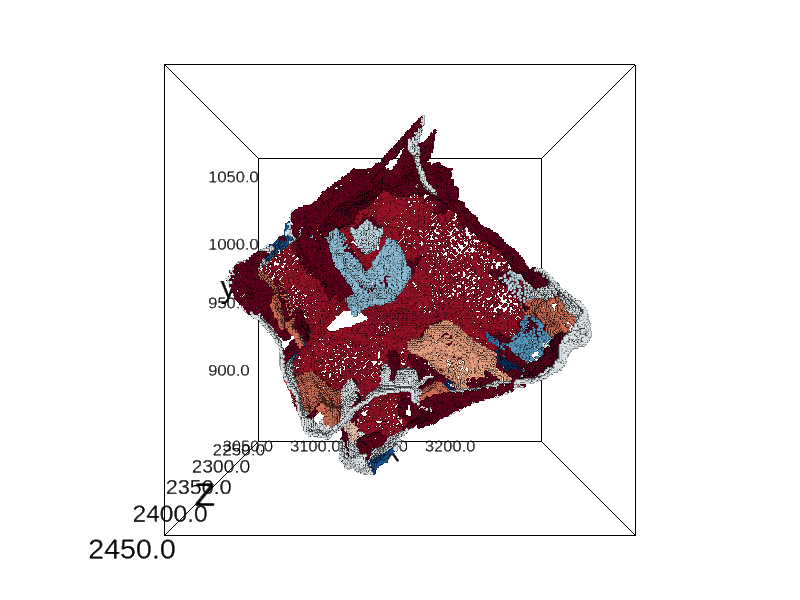

In [28]:
b = train_dk[0]
b.describe()
b.show()

## DataLoaders

In [29]:
# and DataLoaders
#batch_size = 32
#workers = 

train_dl = DataLoader(train_dk, batch_size=32, num_workers=8, shuffle=True, drop_last=True, collate_fn=merge_fn, pin_memory=False)
val_dl = DataLoader(val_dk, batch_size=2, num_workers=2, shuffle=False, collate_fn=merge_fn, pin_memory=False)

In [30]:
train_dl.pin_memory

False

In [31]:
val_dl.pin_memory

False

In [28]:
for i, batch in enumerate(train_dl):
    break

In [29]:
type(batch)

dict

In [30]:
batch

{'coords': tensor([[3103, 1525, 1590,    0],
         [3103, 1525, 1591,    0],
         [3103, 1526, 1591,    0],
         ...,
         [  44, 3057, 3422,   31],
         [  44, 3057, 3422,   31],
         [  44, 3057, 3422,   31]]),
 'features': tensor([[-0.0393, -0.1166, -0.2235],
         [-0.0549, -0.1323, -0.2549],
         [-0.0706, -0.1479, -0.3020],
         ...,
         [-0.4921, -0.5751, -0.4440],
         [-0.4999, -0.5751, -0.4597],
         [-0.2411, -0.3242, -0.1930]]),
 'labels': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'id': ['scene0470_00.merged',
  'scene0662_00.merged',
  'scene0235_00.merged',
  'scene0654_01.merged',
  'scene0576_02.merged',
  'scene0368_00.merged',
  'scene0360_00.merged',
  'scene0099_01.merged',
  'scene0254_00.merged',
  'scene0031_01.merged',
  'scene0511_01.merged',
  'scene0150_01.merged',
  'scene0121_02.merged',
  'scene0501_01.merged',
  'scene0128_00.merged',
  'scene0369_02.merged',
  'scene0649_00.merged',
  'scene0569_00.merged',
  'scen

In [31]:
len(batch['coords']), sum(batch['num_points'])

(4186851, 4186851)

# Model

In [32]:
# spatial_size  is full_scale
model_config = SparseModelConfig(spatial_size=4096, num_classes=20, num_input_features=3, mode=4,
                                 m=16, num_planes_coeffs=[1, 2, 3, 4, 5, 6, 7])
model_config

SparseModelConfig;
   spatial_size: 4096
   dimension: 3
   block_reps: 1
   m: 16
   num_planes: [16, 32, 48, 64, 80, 96, 112]
   residual_blocks: False
   num_classes: 20
   num_input_features: 3
   mode: 4
   downsample: [2, 2]
   bias: False

In [33]:
class Model(nn.Module):
    def __init__(self, cfg):
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.InputLayer(cfg.dimension, cfg.spatial_size, mode=cfg.mode),
            scn.SubmanifoldConvolution(cfg.dimension, nIn=cfg.num_input_features, nOut=cfg.m, filter_size=3, bias=cfg.bias),
            scn.UNet(cfg.dimension, cfg.block_reps, cfg.num_planes, residual_blocks=cfg.residual_blocks, downsample=cfg.downsample),
            scn.BatchNormReLU(cfg.m),
            scn.OutputLayer(cfg.dimension),
        )
        self.linear = nn.Linear(cfg.m, cfg.num_classes)

    def forward(self, xb):
        x = [xb['coords'], xb['features']]
        x = self.sparseModel(x)
        x = self.linear(x)
        return x

model = Model(model_config)

## Initialization

In [34]:
# the three whales of your pipelane are: the data, the model and the loss (hi, Jeremy)

# the data is represented in Kekas by DataOwner. It is a namedtuple with three fields:
# 'train_dl', 'val_dl', 'test_dl'
# For training process we will need at least two of them, and we can skip 'test_dl' for now
# so we will initialize it with `None` value.
dataowner = DataOwner(train_dl, val_dl, None)

# model is just a pytorch nn.Module, that we created vefore
#model = Net(num_classes=2)

# loss or criterion is also a pytorch nn.Module. For multiloss scenarios it can be a list of nn.Modules
# for our simple example let's use the standart cross entopy criterion
criterion = nn.CrossEntropyLoss()

In [35]:
# Also we need to specify, what model will do with each batch of data on each iteration
# We should define a `step_fn` function
# The code below repeats a `keker.default_step_fn` code to provide you with a concept of step function

def step_fn(model: torch.nn.Module,
            batch: torch.Tensor) -> torch.Tensor:
    """Determine what your model will do with your data.

    Args:
        model: the pytorch module to pass input in
        batch: the batch of data from the DataLoader

    Returns:
        The models forward pass results
    """
    
    # you could define here whatever logic you want
    inp = batch  # here we get an "image" from our dataset
    return model(inp)

In [36]:
# previous preparations was mostly out of scope of Kekas library (except DataKeks creation)
# Now let's dive into kekas a little bit

# firstly, we create a Keker - the core Kekas class, that provides all the keks for your pipeline
keker = Keker(model=model,
              dataowner=dataowner,
              criterion=criterion,
              step_fn=step_fn,                    # previosly defined step function
              target_key="labels",                 # remember, we defined it in the reader_fn for DataKek?              
              opt=torch.optim.SGD,               # optimizer class. if note specifiyng, 
                                                  # an SGD is using by default
              opt_params={"weight_decay": params['wd']})  # optimizer kwargs in dict format (optional too)

# Actually, there are a lot of params for kekers, but this out of scope of this example
# you can read about them in Keker's docstring (but who really reads the docs, huh?)

In [37]:
# before the start of the finetuning procedure let's freeeze all the layers except the last one - the head
# the `freeze` method is mostly inspired (or stolen) from fastai
# but you should define a model's attribute to deal with
# for example, our model is actually model.net, so we need to specify the 'net' attr
# also this method does not freezes batchnorm layers by default. To change this set `freeze_bn=True`

#keker.freeze(model_attr="net")

## Learning Rate Find

In [36]:
# let's find an 'optimal' learning rate with learning rate find procedure
# for details please see the fastai course and this articles:
# https://arxiv.org/abs/1803.09820
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

# NOTE: this is an optional step and you can skip it and use your favorite learning rate

# you MUST specify the logdir to see graphics
# keker will write a tensorboard logs into this folder
# to see them start a tensorboard with `--logdir /path/to/logdir`
# OR you can use keker.plot_kek_lr method (see cell below)
keker.kek_lr(final_lr=0.1, logdir="logdir_lr")

Epoch 1/1: 100% 32/32 [03:09<00:00,  4.23s/it, loss=2.4019]
End of LRFinder



In [37]:
keker.plot_kek_lr(logdir="logdir_lr")

In [38]:
# Ok, now let's start training!
# It's as simple as:
keker.kek_one_cycle(cycle_len=params['n_epoch'], max_lr=params['max_lr'],  div_factor=1000, increase_fraction=0.1, logdir=logdir)

Epoch 1/384: 100% 32/32 [03:34<00:00,  4.02s/it, loss=1.9562, val_loss=1.6875]
Epoch 2/384: 100% 32/32 [03:33<00:00,  3.88s/it, loss=1.4185, val_loss=1.2118]
Epoch 3/384: 100% 32/32 [03:32<00:00,  3.93s/it, loss=1.1835, val_loss=1.0601]
Epoch 4/384: 100% 32/32 [03:31<00:00,  3.82s/it, loss=1.0920, val_loss=0.9411]
Epoch 5/384: 100% 32/32 [03:31<00:00,  3.87s/it, loss=1.0347, val_loss=0.9272]
Epoch 6/384: 100% 32/32 [03:31<00:00,  4.05s/it, loss=0.9638, val_loss=0.8830]
Epoch 7/384: 100% 32/32 [03:31<00:00,  3.91s/it, loss=0.9296, val_loss=0.8580]
Epoch 8/384: 100% 32/32 [03:33<00:00,  3.94s/it, loss=0.9190, val_loss=0.8736]
Epoch 9/384: 100% 32/32 [03:29<00:00,  3.89s/it, loss=0.9172, val_loss=0.8083]
Epoch 10/384: 100% 32/32 [03:29<00:00,  3.64s/it, loss=0.8750, val_loss=0.8964]
Epoch 11/384: 100% 32/32 [03:30<00:00,  4.20s/it, loss=0.8685, val_loss=0.7752]
Epoch 12/384: 100% 32/32 [03:34<00:00,  3.68s/it, loss=0.8685, val_loss=0.8704]
Epoch 13/384: 100% 32/32 [03:31<00:00,  4.06s/it,

Epoch 103/384: 100% 32/32 [03:34<00:00,  3.93s/it, loss=0.6153, val_loss=0.6027]
Epoch 104/384: 100% 32/32 [03:35<00:00,  3.97s/it, loss=0.6638, val_loss=0.6715]
Epoch 105/384: 100% 32/32 [03:34<00:00,  3.93s/it, loss=0.6650, val_loss=0.5864]
Epoch 106/384: 100% 32/32 [03:31<00:00,  3.86s/it, loss=0.6314, val_loss=0.6349]
Epoch 107/384: 100% 32/32 [03:31<00:00,  3.69s/it, loss=0.6356, val_loss=0.6936]
Epoch 108/384: 100% 32/32 [03:34<00:00,  4.08s/it, loss=0.6134, val_loss=0.5584]
Epoch 109/384: 100% 32/32 [03:31<00:00,  3.84s/it, loss=0.6343, val_loss=0.7003]
Epoch 110/384: 100% 32/32 [03:33<00:00,  3.92s/it, loss=0.6408, val_loss=0.5999]
Epoch 111/384: 100% 32/32 [03:35<00:00,  4.02s/it, loss=0.6313, val_loss=0.5408]
Epoch 112/384: 100% 32/32 [03:34<00:00,  3.67s/it, loss=0.6550, val_loss=0.6185]
Epoch 113/384: 100% 32/32 [03:30<00:00,  3.78s/it, loss=0.6543, val_loss=0.6620]
Epoch 114/384: 100% 32/32 [03:33<00:00,  4.06s/it, loss=0.6438, val_loss=0.7548]
Epoch 115/384: 100% 32/32 [0

Epoch 204/384: 100% 32/32 [03:32<00:00,  4.04s/it, loss=0.5873, val_loss=0.5431]
Epoch 205/384: 100% 32/32 [03:34<00:00,  4.08s/it, loss=0.5790, val_loss=0.5733]
Epoch 206/384: 100% 32/32 [03:33<00:00,  3.73s/it, loss=0.5956, val_loss=0.5249]
Epoch 207/384: 100% 32/32 [03:32<00:00,  3.81s/it, loss=0.5900, val_loss=0.5212]
Epoch 208/384: 100% 32/32 [03:32<00:00,  3.91s/it, loss=0.5764, val_loss=0.5171]
Epoch 209/384: 100% 32/32 [03:32<00:00,  3.69s/it, loss=0.6046, val_loss=0.5786]
Epoch 210/384: 100% 32/32 [03:34<00:00,  3.91s/it, loss=0.5928, val_loss=0.7428]
Epoch 211/384: 100% 32/32 [03:32<00:00,  4.03s/it, loss=0.5783, val_loss=0.6324]
Epoch 212/384: 100% 32/32 [03:32<00:00,  4.05s/it, loss=0.5804, val_loss=0.6504]
Epoch 213/384: 100% 32/32 [03:32<00:00,  3.89s/it, loss=0.5901, val_loss=0.5377]
Epoch 214/384: 100% 32/32 [03:32<00:00,  3.76s/it, loss=0.5783, val_loss=0.5456]
Epoch 215/384: 100% 32/32 [03:36<00:00,  3.99s/it, loss=0.5931, val_loss=0.5772]
Epoch 216/384: 100% 32/32 [0

Epoch 305/384: 100% 32/32 [03:33<00:00,  4.01s/it, loss=0.5307, val_loss=0.5225]
Epoch 306/384: 100% 32/32 [03:32<00:00,  3.80s/it, loss=0.5339, val_loss=0.5331]
Epoch 307/384: 100% 32/32 [03:32<00:00,  3.87s/it, loss=0.5457, val_loss=0.5800]
Epoch 308/384: 100% 32/32 [03:54<00:00,  4.91s/it, loss=0.5182, val_loss=0.5009]
Epoch 309/384: 100% 32/32 [03:31<00:00,  3.85s/it, loss=0.5158, val_loss=0.4982]
Epoch 310/384: 100% 32/32 [03:31<00:00,  3.76s/it, loss=0.5236, val_loss=0.4768]
Epoch 311/384: 100% 32/32 [03:33<00:00,  4.41s/it, loss=0.4929, val_loss=0.5105]
Epoch 312/384: 100% 32/32 [03:31<00:00,  3.94s/it, loss=0.5302, val_loss=0.5330]
Epoch 313/384: 100% 32/32 [03:32<00:00,  3.76s/it, loss=0.5391, val_loss=0.5102]
Epoch 314/384: 100% 32/32 [03:33<00:00,  4.05s/it, loss=0.5285, val_loss=0.5400]
Epoch 315/384: 100% 32/32 [03:31<00:00,  4.05s/it, loss=0.5191, val_loss=0.5169]
Epoch 316/384: 100% 32/32 [03:35<00:00,  3.83s/it, loss=0.5212, val_loss=0.4952]
Epoch 317/384: 100% 32/32 [0

In [39]:
keker.plot_kek(logdir=logdir)